In [39]:
import pandas as pd
import numpy as np

from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from xgboost import XGBClassifier, DMatrix, train

import matplotlib.pyplot as plt

In [40]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [41]:

train_dataframe = pd.read_csv('data/train.csv')
test_dataframe = pd.read_csv('data/test.csv')

train_dataframe.describe()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,...,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.000000e+06,2.980192e+03,1.515857e+02,1.509754e+01,2.713154e+02,5.166262e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,...,3.746200e-02,3.782075e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075150e-02,3.923925e-02,3.161850e-02,1.771335e+00
std,1.154701e+06,2.890482e+02,1.099611e+02,8.546731e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,...,1.898910e-01,1.907625e-01,1.088629e-01,1.256813e-01,1.029465e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,8.938060e-01
min,0.000000e+00,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.999998e+05,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.000000e+06,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.999999e+06,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
max,3.999999e+06,4.383000e+03,4.070000e+02,6.400000e+01,1.602000e+03,6.470000e+02,7.666000e+03,3.010000e+02,2.790000e+02,2.720000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


In [42]:
# Remove the only Cover_Type 5 sample
idx = train_dataframe[train_dataframe["Cover_Type"] == 5].index
train_dataframe.drop(idx, axis=0, inplace=True)

# Droping same values columns
cols = ["Soil_Type7", "Soil_Type15"]

train_dataframe.drop(cols, axis=1, inplace=True)
test_dataframe.drop(cols, axis=1, inplace=True)

In [43]:
encoder = LabelEncoder()
train_dataframe["Cover_Type"] = encoder.fit_transform(train_dataframe["Cover_Type"])

In [44]:
train_dataframe["Aspect"][train_dataframe["Aspect"] < 0] += 360
train_dataframe["Aspect"][train_dataframe["Aspect"] > 359] -= 360

test_dataframe["Aspect"][test_dataframe["Aspect"] < 0] += 360
test_dataframe["Aspect"][test_dataframe["Aspect"] > 359] -= 360

train_dataframe["Aspect"] *= 2*np.pi/360
test_dataframe["Aspect"] *= 2*np.pi/360

In [45]:
# Manhhattan Distance
train_dataframe["Manhhattan_Distance"] = np.abs(train_dataframe["Horizontal_Distance_To_Hydrology"])+np.abs(train_dataframe["Vertical_Distance_To_Hydrology"])
test_dataframe["Manhhattan_Distance"] = np.abs(test_dataframe["Horizontal_Distance_To_Hydrology"])+np.abs(test_dataframe["Vertical_Distance_To_Hydrology"])

# Euclidian Distance
train_dataframe["Euclidian_Distance"] = (train_dataframe["Horizontal_Distance_To_Hydrology"]**2 + train_dataframe["Vertical_Distance_To_Hydrology"]**2)**0.5
test_dataframe["Euclidian_Distance"] = (test_dataframe["Horizontal_Distance_To_Hydrology"]**2 + test_dataframe["Vertical_Distance_To_Hydrology"]**2)**0.5


In [46]:
soil_features = [x for x in train_dataframe.columns if x.startswith("Soil_Type")]
train_dataframe["Soil_Type_Count"] = train_dataframe[soil_features].sum(axis=1)
test_dataframe["Soil_Type_Count"] = test_dataframe[soil_features].sum(axis=1)

wilderness_features = [x for x in train_dataframe.columns if x.startswith("Wilderness_Area")]
train_dataframe["Wilderness_Area_Count"] = train_dataframe[wilderness_features].sum(axis=1)
test_dataframe["Wilderness_Area_Count"] = test_dataframe[wilderness_features].sum(axis=1)

In [47]:
train_dataframe.loc[train_dataframe["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
test_dataframe.loc[test_dataframe["Hillshade_9am"] < 0, "Hillshade_9am"] = 0

train_dataframe.loc[train_dataframe["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
test_dataframe.loc[test_dataframe["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0

train_dataframe.loc[train_dataframe["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
test_dataframe.loc[test_dataframe["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

train_dataframe.loc[train_dataframe["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
test_dataframe.loc[test_dataframe["Hillshade_9am"] > 255, "Hillshade_9am"] = 255

train_dataframe.loc[train_dataframe["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
test_dataframe.loc[test_dataframe["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255

train_dataframe.loc[train_dataframe["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
test_dataframe.loc[test_dataframe["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

train_dataframe["Hillshade_9am"] /= 255
test_dataframe["Hillshade_9am"] /= 255

train_dataframe["Hillshade_3pm"] /= 255
test_dataframe["Hillshade_3pm"] /= 255

train_dataframe["Hillshade_Noon"] /= 255
test_dataframe["Hillshade_Noon"] /= 255

In [48]:

cols = [
    "Elevation",
    "Aspect",
    "Manhhattan_Distance",
    "Euclidian_Distance",
    "Soil_Type_Count",
    "Wilderness_Area_Count",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

scaler = RobustScaler()

train_dataframe[cols] = scaler.fit_transform(train_dataframe[cols])
test_dataframe[cols] = scaler.transform(test_dataframe[cols])

In [49]:
train_dataframe = reduce_mem_usage(train_dataframe)
test_dataframe = reduce_mem_usage(test_dataframe)

Memory usage after optimization is: 445.62 MB
Decreased by 76.9%
Memory usage after optimization is: 70.57 MB
Decreased by 83.8%


In [50]:
# train_dataframe = train_dataframe.dropna()

train_dataframe.head()
train_dataframe.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Manhhattan_Distance,Euclidian_Distance,Soil_Type_Count,Wilderness_Area_Count
count,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,...,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3999999.0,3999999.0
mean,1.999999e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.071275e-02,1.220750e-02,4.075151e-02,3.923926e-02,3.161851e-02,7.529129e-01,NaN,NaN,NaN,NaN
std,1.154701e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.029466e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,7.937505e-01,0.000000e+00,0.000000e+00,0.0,0.0
min,0.000000e+00,-2.611328e+00,-6.557617e-01,-1.545898e+00,-1.214844e+00,-4.703125e+00,-1.116211e+00,-6.230469e+00,-6.480469e+00,-2.628906e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.014648e+00,-9.697266e-01,-1.0,-1.0
25%,9.999995e+05,-4.506836e-01,-3.332520e-01,-4.545898e-01,-4.104004e-01,-3.647461e-01,-3.979492e-01,-5.712891e-01,-5.185547e-01,-5.000000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.216309e-01,-4.130859e-01,-1.0,0.0
50%,1.999999e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
75%,2.999998e+06,5.493164e-01,6.665039e-01,5.454102e-01,5.898438e-01,6.352539e-01,6.020508e-01,4.284668e-01,4.814453e-01,5.000000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.781250e-01,5.869141e-01,0.0,0.0
max,3.999999e+06,3.101562e+00,1.305664e+00,4.546875e+00,5.535156e+00,8.328125e+00,4.039062e+00,1.057617e+00,1.148438e+00,2.091797e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,6.125000e+00,5.718750e+00,6.0,2.0


In [51]:

X = train_dataframe.drop("Cover_Type", axis=1).values
y = train_dataframe["Cover_Type"].values

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

classes_number = len(train_dataframe["Cover_Type"].unique())

In [52]:
class_weights_train = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights_val = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_val),y=y_val)


print(classes_number, train_dataframe["Cover_Type"].unique())

print(0,len(train_dataframe[train_dataframe["Cover_Type"] == 0]))
print(1,len(train_dataframe[train_dataframe["Cover_Type"] == 1]))
print(2,len(train_dataframe[train_dataframe["Cover_Type"] == 2]))
print(3,len(train_dataframe[train_dataframe["Cover_Type"] == 3]))
print(4,len(train_dataframe[train_dataframe["Cover_Type"] == 4]))
print(5,len(train_dataframe[train_dataframe["Cover_Type"] == 5]))

print(np.unique(y_train))

6 [0 1 2 4 5 3]
0 1468136
1 2262087
2 195712
3 377
4 11426
5 62261
[0 1 2 3 4 5]


Class=0, n=1174959 (36.717%)
Class=1, n=1809037 (56.532%)
Class=5, n=49676 (1.552%)
Class=2, n=156931 (4.904%)
Class=4, n=9103 (0.284%)
Class=3, n=293 (0.009%)


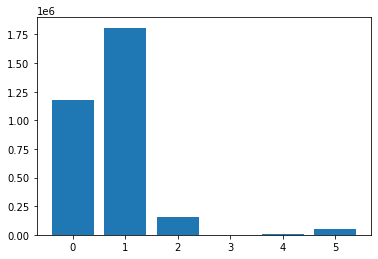

In [53]:
from collections import Counter

counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=293177 (36.647%)
Class=2, n=38781 (4.848%)
Class=1, n=453050 (56.631%)
Class=4, n=2323 (0.290%)
Class=5, n=12585 (1.573%)
Class=3, n=84 (0.011%)


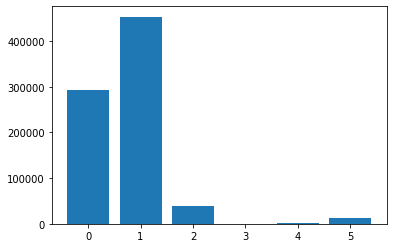

In [54]:
from collections import Counter

counter = Counter(y_val)
for k,v in counter.items():
    per = v / len(y_val) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

In [55]:
import gc

del train_dataframe
gc.collect()

6515

In [56]:

params = {
    'learning_rate': 0.03, 
    'reg_lambda': 17.1, 
    'reg_alpha': 1.2e-04, 
    'subsample': 0.25, 
    'colsample_bytree': 0.94, 
    'max_depth': 10,
    'grow_policy': 'depthwise'
}

model = XGBClassifier(
    weights = class_weights_train,
    random_state = 69,
    tree_method='gpu_hist',
    objective = 'multi:softmax',
    sampling_method = 'gradient_based',
    n_estimators=10000,
    n_jobs=-1,
    num_class = classes_number,
    use_label_encoder=False,
    eval_metric = 'mlogloss',
    verbosity=2,
    **params
)

In [57]:
model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_val, y_val)], verbose=10)

[00:09:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.71332
[10]	validation_0-mlogloss:1.18779
[20]	validation_0-mlogloss:0.87102
[30]	validation_0-mlogloss:0.66672
[40]	validation_0-mlogloss:0.51716
[50]	validation_0-mlogloss:0.41204
[60]	validation_0-mlogloss:0.33415
[70]	validation_0-mlogloss:0.27597
[80]	validation_0-mlogloss:0.23357
[90]	validation_0-mlogloss:0.19998
[100]	validation_0-mlogloss:0.17456
[110]	validation_0-mlogloss:0.15633
[120]	validation_0-mlogloss:0.14130
[130]	validation_0-mlogloss:0.12990
[140]	validation_0-mlogloss:0.12123
[150]	validation_0-mlogloss:0.11455
[160]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.94,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=-1,
              num_class=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=69, reg_alpha=0.00012,
              reg_lambda=17.1, sampling_method='gradient_based',
              scale_pos_weight=None, subsample=0.25, ...)

In [58]:
#model.save_model("xgboost.json")

In [59]:
val_predictions = model.predict(x_val)
test_predictions = model.predict(test_dataframe)

print(accuracy_score(y_val, val_predictions))

0.961965


In [60]:

submission_df = pd.read_csv("data/sample_submission.csv")

test_ids = test_dataframe.Id.values.tolist()
print(len(test_predictions))
print(len(test_ids))
submission_df = pd.DataFrame(list(zip(test_ids, test_predictions)), columns=["Id", "Cover_Type"])

submission_df.columns = ["Id", "Cover_Type"]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1000000
1000000


,Id,Cover_Type
0,4000000,1
1,4000001,1
2,4000002,1
3,4000003,1
4,4000004,1


Class=1, n=512754 (51.275%)
Class=2, n=77763 (7.776%)
Class=0, n=388072 (38.807%)
Class=5, n=14947 (1.495%)
Class=4, n=6317 (0.632%)
Class=3, n=147 (0.015%)


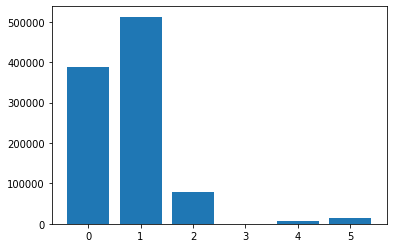

In [61]:
from collections import Counter

counter = Counter(test_predictions)
for k,v in counter.items():
    per = v / len(test_predictions) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

In [62]:
submission_df.head()

,Id,Cover_Type
0,4000000,1
1,4000001,1
2,4000002,1
3,4000003,1
4,4000004,1


In [63]:

test_predictions = encoder.inverse_transform(model.predict(test_dataframe))

print(test_predictions)

[2 2 2 ... 2 1 3]


In [64]:

submission_df = pd.read_csv("data/sample_submission.csv")

test_ids = test_dataframe.Id.values.tolist()
print(len(test_predictions))
print(len(test_ids))
submission_df = pd.DataFrame(list(zip(test_ids, test_predictions)), columns=["Id", "Cover_Type"])

submission_df.columns = ["Id", "Cover_Type"]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1000000
1000000


,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


Class=2, n=512754 (51.275%)
Class=3, n=77763 (7.776%)
Class=1, n=388072 (38.807%)
Class=7, n=14947 (1.495%)
Class=6, n=6317 (0.632%)
Class=4, n=147 (0.015%)


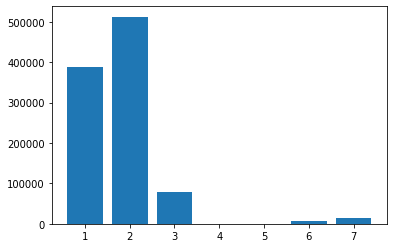

In [65]:
from collections import Counter

counter = Counter(test_predictions)
for k,v in counter.items():
    per = v / len(test_predictions) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()